In [1]:
import os
import io
import cv2
import PyPDF2
import easyocr
import logging
import camelot
import datetime
import itertools
import pytesseract
import numpy as np
import pandas as pd
from wand.image import Image
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from pdf2image import convert_from_path
from maskrcnn import inference

In [49]:
class TableExtraction:
    def __init__(self):
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        os.environ['PATH'] += r';C:\Program Files\Tesseract-OCR'
        logger = logging.getLogger('easyocr')
        logger.setLevel(logging.ERROR)

        self.file_path = ''
        # pytesseract config
        self.custom_config = r'--oem 1 --psm 1 -l rus'

    def pdf_file_to_array(self, dpi=300):
        poppler_path = os.path.join(os.environ.get(
            'PROGRAMFILES', 'C:\\Program Files'), 'poppler-23.07.0', 'Library', 'bin')
        images = convert_from_path(
            self.file_path, dpi=dpi, poppler_path=poppler_path)
        return [np.array(image) for image in images]
    
    def image_file_to_array(self):
        # Открываем изображение с использованием Pillow
        img = cv2.imread(self.file_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Преобразуем изображение в массив NumPy
        img_array = np.array(img_rgb)
        return [img_array]

    def grayzation(self, images_array):
        gray_images = []
        for image in images_array:
            gray_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        return gray_images

    def show_gray_images(self):
        for gray_image in self.gray_images:
            plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def binarization(self, images_array):
        threshold_images = []
        for gray_image in images_array:
            _, threshold_image = cv2.threshold(
                gray_image, 200, 255, cv2.THRESH_BINARY)
            threshold_images.append(threshold_image)
        return threshold_images

    def show_threshold_images(self):
        for threshold_image in self.threshold_images:
            plt.imshow(cv2.cvtColor(threshold_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_tables_with_rcnn(self):
        self.tables_bboxes = []
        self.tables_borders = []
        tables = []

        # low_quality_images_arrays = self.pdf_file_to_array(dpi=self.low_dpi)
        low_quality_images_arrays = self.images_arrays

        for num, image in enumerate(low_quality_images_arrays):
            weights = os.getcwd() + r"\maskrcnn\weights\table_plot.pth"
            mode = "table_plot"
            _, boxes, labels = inference.get_bboxes_of_objects(image, weights, threshold = 0.9, mode=mode)
            # print("tables", boxes, labels)
            # print("tables", len(boxes), len(labels))
            
            for box, label in zip(boxes, labels):
                if label == "table":
                    [x1, y1], [x2, y2] = box

                    # croped_image = image[y1:y2, x1:x2]
                    # plt.imshow(cv2.cvtColor(croped_image, cv2.COLOR_BGR2RGB))
                    # plt.axis('off')
                    # plt.show()

                    # [x1, y1], [x2, y2] = np.array(box) * int(self.high_dpi/self.low_dpi)
                    self.tables_bboxes.append((x1, y1, x2, y2))
                    croped_gray_image = self.gray_images[num][y1:y2, x1:x2]
                    tables.append(croped_gray_image)

                    # # For dataset creation
                    # current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                    # output_filename =  f"output_{current_time}_{num}.png"
                    # output_path = os.path.join('output_folder', output_filename)
                    # cv2.imwrite(output_path, croped_gray_image)

                    # _, croped_threshold_image = cv2.threshold(croped_gray_image, 200, 255, cv2.THRESH_BINARY)
                    # boxes = pytesseract.image_to_boxes(croped_threshold_image, config=self.custom_config)
                    # box_lines = boxes.strip().split('\n')
                    # boxes_list = [line.split() for line in box_lines]
                    # borders = []
                    # height, width = croped_gray_image.shape
                    # epsilon = (height + width) * 0.05

                    # # Check if there are lines on the croped image
                    # if boxes_list[0] != []:
                    #     for box in boxes_list:
                    #         if box[0] == '~': # and ((abs(int(box[1]) - int(box[3])) <= epsilon) or (abs(int(box[2]) - int(box[4])) <= epsilon))
                    #             x1, y1, x2, y2 = int(box[1]), int(box[2]), int(box[3]), int(box[4])
                    #             borders.append([x1, y1, x2, y2])
                    #             # cv2.rectangle(copy_image, (x1, height - y1), (x2, height - y2), (0, 255, 0), 1)

                    # # self.tables_borders.append(list(np.array(borders) * int(self.high_dpi/self.low_dpi)))
                    # self.tables_borders.append(list(np.array(borders)))
            return tables

    def classify_table(self, table_text):
        self.keywords = ["марка", "стали", "временное", "сопротивление",
                         "предел", "текучести", "относительное", "удлинение"]
        self.error_threshold = 0.2
        self.keyword_importance = 0.8

        keywords_found = []

        def partial_compare(word, keyword):
            max_length = max(len(word), len(keyword))
            errors = sum(1 for w, k in zip(word, keyword) if w != k)
            error_ratio = errors / max_length
            return error_ratio <= self.error_threshold

        for keyword in self.keywords:
            found = any(partial_compare(keyword, word.lower())
                        for word in table_text.split())
            if found:
                keywords_found.append(keyword)

        total_keywords = len(self.keywords)
        found_keywords = len(keywords_found)
        confidence = self.keyword_importance * \
            (found_keywords / total_keywords)

        if confidence >= self.error_threshold:
            return True
        else:
            return False

    def filter_tables_by_classification(self):
        filtered_tables = []
        for table in self.tables:
            text = pytesseract.image_to_string(
                table, config=self.custom_config).replace('\n', ' ')
            if self.classify_table(text):
                filtered_tables.append(table)
        return filtered_tables

    def show_table_images(self):
        for table in self.tables:
            plt.imshow(cv2.cvtColor(table, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_lines_Hough(self, tables):
        tables_lines = []

        # Extract vertical and horizontal lines in an image using a kernel transform
        for num, image in enumerate(tables):
            height, width = image.shape
            _, threshold_image = cv2.threshold(
                image, 127, 255, cv2.THRESH_BINARY)
            inverted_image = cv2.bitwise_not(threshold_image)

            # Horizontal
            hor = np.array([[1, 1, 1, 1, 1, 1]])
            vertical_lines_eroded_image = cv2.erode(
                inverted_image, hor, iterations=10)
            vertical_lines_eroded_image = cv2.dilate(
                vertical_lines_eroded_image, hor, iterations=10)

            # Vertical
            ver = np.array([[1],
                            [1],
                            [1],
                            [1],
                            [1],
                            [1],
                            [1]])
            horizontal_lines_eroded_image = cv2.erode(
                inverted_image, ver, iterations=10)
            horizontal_lines_eroded_image = cv2.dilate(
                horizontal_lines_eroded_image, ver, iterations=10)

            # Combine
            combined_image = cv2.add(
                vertical_lines_eroded_image, horizontal_lines_eroded_image)

            # Dilate
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
            combined_image_dilated = cv2.dilate(
                combined_image, kernel, iterations=5)

            lines = cv2.HoughLinesP(
                combined_image_dilated, 1, np.pi / 180, 50, None, 50, 10)

            # Recurrent function for checking arrays for emptiness
            def is_not_empty_element(structure):
                if isinstance(structure, list) or isinstance(structure, np.ndarray):
                    return any(is_not_empty_element(item) for item in structure)
                elif isinstance(structure, int) or isinstance(structure, np.intc):
                    return True
                else:
                    return False

            # Finding all vertical and horizontal lines of a table
            vertical_lines = []
            horizontal_lines = []

            if is_not_empty_element(lines):
                borders = np.concatenate(lines, axis=0)

                # Tolerance parameters at which we consider that the lines are even and intersect
                epsilon = (height + width) * 0.01
                for x1, y1, x2, y2 in borders:
                    if abs(x1 - x2) <= epsilon and abs(y1 - y2) > epsilon:  # Vertical lines
                        vertical_lines.append(
                            (int((x1 + x2) / 2), height - y1, int((x1 + x2) / 2), height - y2))
                    elif abs(y1 - y2) <= epsilon and abs(x1 - x2) > epsilon:  # Horizontal lines
                        horizontal_lines.append(
                            (int(x1), height - int((y1 + y2) / 2), int(x2), height - int((y1 + y2) / 2)))

            # Save lines for visualisation
            tables_lines.append((vertical_lines, horizontal_lines))
        return tables_lines

    def show_tables_lines(self):
        for num, table in enumerate(self.tables):
            copy_image = table.copy()
            height, width = copy_image.shape
            vertical_lines, horizontal_lines = self.tables_lines[num]
            for line in vertical_lines:
                x1, y1, x2, y2 = line
                cv2.rectangle(copy_image, (x1, height - y1),
                              (x2, height - y2), (0, 255, 0), 5)
            for line in horizontal_lines:
                x1, y1, x2, y2 = line
                cv2.rectangle(copy_image, (x1, height - y1),
                              (x2, height - y2), (0, 255, 0), 5)

            plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_cells(self, tables):
        all_cells = []

        for num, image in enumerate(tables):
            cells = []
            copy_image = image.copy()
            weights = os.getcwd() + "\maskrcnn\weights\cell_detection.pth"
            mode = "cells"
            _, boxes, labels = inference.get_bboxes_of_objects(copy_image, weights, threshold=0.8, mode=mode)
            # print("cells", boxes, labels)
            # print("cells", len(boxes), len(labels))

            for box, _ in zip(boxes, labels):
                [x1, y1], [x2, y2] = box
                cells.append((x1, y1, x2, y2))

                # cv2.rectangle(copy_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()
            
            all_cells.append(cells)
        return(all_cells)

    def split_into_headers_and_records_maskrcnn(self, tables):
        all_headers = []
        all_records = []

        for num, image in enumerate(tables):
            cells = []
            headers = []
            
            copy_image = image.copy()
            copy_image = cv2.cvtColor(copy_image, cv2.COLOR_GRAY2BGR)
            
            weights = os.getcwd() + "\maskrcnn\weights\cell_classification.pth"
            mode = "cells"
            _, boxes, labels = inference.get_bboxes_of_objects(copy_image, weights, threshold=0.8, mode=mode)
            # print("split", boxes, len(boxes))
            # print("split", labels, len(labels))

            for box, label in zip(boxes, labels):
                [x1, y1], [x2, y2] = box
                
                if label == "head":
                    headers.append((x1, y1, x2, y2))
                    cv2.rectangle(copy_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    label_text = f"{label}"
                    cv2.putText(copy_image, label_text, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                elif label == "cell":
                    cells.append((x1, y1, x2, y2))
                    cv2.rectangle(copy_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    label_text = f"{label}"
                    cv2.putText(copy_image, label_text, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            all_headers.append(headers)
            all_records.append(cells)
                    
            plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        
        return (all_headers, all_records)


    def get_nodes(self, tables):
        all_tables_nodes = []
        # Finding the coordinates of table nodes
        for num, image in enumerate(tables):
            height, width = image.shape
            epsilon = (height + width) * 0.01
            table_nodes = []
            nodes_sorted_xy = []
            if self.tables_lines[num][0] and self.tables_lines[num][1]:
                for v_line, h_line in itertools.product(self.tables_lines[num][0], self.tables_lines[num][1]):
                    v_x1, v_y1, v_x2, v_y2 = v_line
                    h_x1, h_y1, h_x2, h_y2 = h_line

                    # Checking if there are lines or whether they end in the neighborhood
                    if (((h_x1 - epsilon <= v_x1 <= h_x2 + epsilon) and
                        (v_y1 - epsilon <= h_y1 <= v_y2 + epsilon)) or
                        (abs(h_x1 - v_x1) <= epsilon and v_y1 - epsilon <= h_y1 <= v_y2 + epsilon) or
                        (abs(h_x2 - v_x1) <= epsilon and v_y1 - epsilon <= h_y1 <= v_y2 + epsilon) or
                        (abs(h_y1 - v_y1) <= epsilon and h_x1 - epsilon <= v_x1 <= h_x2 + epsilon) or
                            (abs(h_y1 - v_y2) <= epsilon and h_x1 - epsilon <= v_x1 <= h_x2 + epsilon)):
                        table_nodes.append((v_x1, h_y1))

                    if v_x1 <= epsilon or v_y1 <= epsilon or abs(v_x1 - width) <= epsilon or abs(v_y1 - height) <= epsilon:
                        table_nodes.append((v_x1, v_y1))

                    if v_x2 <= epsilon or v_y2 <= epsilon or abs(v_x2 - width) <= epsilon or abs(v_y2 - height) <= epsilon:
                        table_nodes.append((v_x2, v_y2))

                    if h_x1 <= epsilon or h_y1 <= epsilon or abs(h_x1 - width) <= epsilon or abs(h_y1 - height) <= epsilon:
                        table_nodes.append((h_x1, h_y1))

                    if h_x2 <= epsilon or h_y2 <= epsilon or abs(h_x2 - width) <= epsilon or abs(h_y2 - height) <= epsilon:
                        table_nodes.append((h_x2, h_y2))

                    if v_y1 <= epsilon or v_y2 <= epsilon:
                        table_nodes.append((0, 0))
                        table_nodes.append((width, 0))

                if table_nodes == []:
                    all_tables_nodes.append([])
                    break

                # Create a copy of the table_nodes list for modification
                modified_table_nodes = np.array(table_nodes.copy())

                # Looking for points that are in the neighborhood of each other using KDTree
                kdtree = KDTree(modified_table_nodes)

                neighborhood_nodes = []
                visited = set()

                for node in modified_table_nodes:
                    if tuple(node) in visited:
                        continue

                    idxs = kdtree.query_ball_point(node, epsilon)
                    visited.update(
                        tuple(modified_table_nodes[i]) for i in idxs)

                    if len(idxs) > 1:
                        mean_node = np.round(
                            np.mean(modified_table_nodes[idxs], axis=0)).astype(int)
                        neighborhood_nodes.append(tuple(mean_node))
                    else:
                        neighborhood_nodes.append(tuple(node))

                # Sort nodes by x and y axis
                nodes_sorted_x = sorted(neighborhood_nodes, key=lambda x: x[0])

                for i in range(len(nodes_sorted_x)-1):
                    if abs(nodes_sorted_x[i][0] - nodes_sorted_x[i+1][0]) <= epsilon:
                        nodes_sorted_x[i+1] = (nodes_sorted_x[i]
                                               [0], nodes_sorted_x[i+1][1])

                nodes_sorted_y = sorted(nodes_sorted_x, key=lambda x: x[1])

                for i in range(len(nodes_sorted_y)-1):
                    if abs(nodes_sorted_y[i][1] - nodes_sorted_y[i+1][1]) <= epsilon:
                        nodes_sorted_y[i+1] = (nodes_sorted_y[i+1]
                                               [0], nodes_sorted_y[i][1])

                nodes_sorted_xy = sorted(
                    nodes_sorted_y, key=lambda x: (-x[1], x[0]))

                # Delete the same coordinates of a points
                while True:
                    count_x = {}
                    count_y = {}
                    for x, y in nodes_sorted_xy:
                        count_x[x] = count_x.get(x, 0) + 1
                        count_y[y] = count_y.get(y, 0) + 1

                    filtered_points = [
                        (x, y) for x, y in nodes_sorted_xy if count_x[x] > 1 and count_y[y] > 1]
                    # tresh_points = [(x, y) for x, y in nodes_sorted_xy if count_x[x] <= 1 or count_y[y] <= 1]

                    if len(filtered_points) == len(nodes_sorted_xy):
                        break
                    else:
                        nodes_sorted_xy = filtered_points

            all_tables_nodes.append(nodes_sorted_xy)
        return all_tables_nodes

    def show_tables_nodes(self):
        for num, table in enumerate(self.tables):
            copy_image = table.copy()
            height, width = copy_image.shape
            if self.tables_nodes[num]:
                for node in self.tables_nodes[num]:
                    x, y = node
                    cv2.rectangle(copy_image, (x, height - y),
                                  (x + 10, height - y + 10), (0, 255, 0), 10)

            plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def image_to_text_tesseract(self, image):
        text = pytesseract.image_to_string(
            image, config=self.custom_config).replace('\n', ' ')
        return text

    def image_to_text_easyocr(self, image):
        reader = easyocr.Reader(lang_list=['en', 'ru'], 
                model_storage_directory='easyocr/model',
                user_network_directory='easyocr/user_network',
                gpu=False)
        result = reader.readtext(image)
        text = ''
        for detection in result:
            text += detection[1]
        return text

    def get_rectangles(self):
        tables_rectangles = []

        for num, image in enumerate(self.tables):
            table_text = ''
            height, width = image.shape
            epsilon = (height + width) * 0.01
            tables_nodes = self.tables_nodes[num]
            # Determining the number of rows and columns in a table
            unique_x = set()
            unique_y = set()
            for x, y in tables_nodes:
                unique_x.add(x)
                unique_y.add(y)

            # Create a list of rectangles
            rectangles = []
            for i in range(len(tables_nodes) - 1):
                current_node = tables_nodes[i]
                if tables_nodes[i + 1][1] == current_node[1]:
                    next_x_node = tables_nodes[i + 1]
                else:
                    continue
                # Find the next nodes along the y-axis for the current nodes
                next_y_nodes = [node for node in tables_nodes if abs(
                    node[0] - current_node[0]) <= epsilon and node[1] < current_node[1]]
                flag = True
                for next_y_node in next_y_nodes:
                    opposite_node = (next_x_node[0], next_y_node[1])
                    if flag:
                        for node in tables_nodes:
                            if abs(node[0] - opposite_node[0]) <= epsilon and abs(node[1] - opposite_node[1]) <= epsilon:
                                # Build a rectangle based on the found nodes
                                rectangle = (
                                    (current_node[0], current_node[1]), (opposite_node[0], opposite_node[1]))
                                rectangles.append(rectangle)
                                flag = False
                                break

            rectangles = sorted(rectangles, key=lambda x: (- x[0][1], x[0][0]))
            tables_rectangles.append(rectangles)
        return tables_rectangles

    def show_rectangles(self):
        pass

    def osr_detection(self, tables_rectangles):
        tables_cell_text = []
        output_folder = "output"
        print("table_rect", len(tables_rectangles), tables_rectangles)
        for num, image in enumerate(self.tables):
            cell_text = {}
            height, width = image.shape
            epsilon = (height + width) * 0.01
            # Creating an empty array to store table data
            # table_data = [['' for _ in range(num_columns)] for _ in range(num_rows)]
            for i, rectangle in enumerate(tables_rectangles[num]):
                x1, y1, x2, y2 = rectangle
                # x1, y1 = rectangle[0]
                # x2, y2 = rectangle[1]

                # Crop images at cell borders
                # _, threshold_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
                margin = 5
                cell_image = image[max(0, y1 - margin):min(image.shape[0], y2 + margin), max(0, x1 - margin):min(image.shape[1], x2 + margin)]

                # cell_image = threshold_image[max(0, (height - y1) - 2):min(height, (height - y2) + 2),
                #                    max(0, x1 - 2):min(width, x2 + 2)]

                if cell_image is not None and np.size(cell_image) != 0:
                    print(cell_image)
                    text = self.image_to_text_easyocr(cell_image)
                    print(text, ' easy')

                    plt.imshow(cv2.cvtColor(cell_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.show()
                
                # For dataset creation
                # current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                # output_filename =  f"output_{current_time}_{num + i}.png"
                # output_path = os.path.join(output_folder, output_filename)
                # cv2.imwrite(output_path, cell_image)

                # if cell_image.shape[0] > epsilon and cell_image.shape[1] > epsilon:
                    # Text recognition with Tesseract
                    # text = self.image_to_text_tesseract(cell_image)
                    # print(text, ' tess')
                    # text = self.image_to_text_easyocr(cell_image)
                    # print(text, ' easy')

                    # cell_text[(x1, y1), (x2, y2)] = text

                    # Determining the position of a cell in a table
                    # row = i // num_columns
                    # column = i % num_columns

                    # Adding cell data
                    # if row < num_rows and column < num_columns:
                    #     table_data[row][column] = text
            # tables_cell_text.append(cell_text)
        return tables_cell_text

    def split_into_headers_and_records(self, rectangles):
        max_y = max(y1 for (x1, y1), (x2, y2) in rectangles)

        prev_y = None
        cell_count = 0
        cell_counts = {}  # Dictionary to store cell counts for each y

        cell_counts = {}
        for (x1, y1), _ in rectangles:
            if y1 in cell_counts:
                cell_counts[y1] += 1
            else:
                cell_counts[y1] = 1

        # Find the y where the number of cells changes
        sorted_cell_counts = sorted(cell_counts.items())
        previous_value = None
        records = 1

        for y1, count in sorted_cell_counts:
            if previous_value is None:
                previous_value = count
            elif count != previous_value:
                change_y = y1
                break
            else:
                records += 1

        record_cells = [((x1, y1), (x2, y2))
                        for (x1, y1), (x2, y2) in rectangles if y1 < change_y]
        header_cells = [((x1, y1), (x2, y2))
                        for (x1, y1), (x2, y2) in rectangles if y1 >= change_y]

        return header_cells, record_cells, previous_value, records

    def show_headers_and_records_cells(self, image, cells, type):
        if type == 'header':
            color = (120, 180, 0)
        elif type == 'record':
            color = (0, 180, 180)
        copy_image = image.copy()
        copy_image = cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB)
        height, width, _ = copy_image.shape
        for cell in cells:
            (x1, y1), (x2, y2) = cell
            cv2.rectangle(copy_image, (x1, height - y1),
                          (x2, height - y2), color, 10)

        plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def create_cell_dict(self, image, cells):
        # Create a dictionary in which the keys will be the coordinates of the current cell,
        # and the values will be the coordinates of the cells immediately below the current one.
        rectangle_dict = {}

        for i, cell1 in enumerate(cells):
            overlapping_cells = []
            (x1_cell1, y1_cell1), (x2_cell1, y2_cell1) = cell1

            for j, cell2 in enumerate(cells):
                if i != j:
                    (x1_cell2, y1_cell2), (x2_cell2, y2_cell2) = cell2
                    if x1_cell1 <= x1_cell2 < x2_cell2 <= x2_cell1 and y1_cell2 == y2_cell1:
                        overlapping_cells.append(cell2)

            # self.show_cells_relationship(image, cell1, overlapping_cells)
            rectangle_dict[cell1] = overlapping_cells

        return rectangle_dict

    def show_cells_relationship(self, image, main_cell, overlapping_cells):
        copy_image = image.copy()
        copy_image = cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB)
        height, width, _ = copy_image.shape

        (x1, y1), (x2, y2) = main_cell
        cv2.rectangle(copy_image, (x1, height - y1),
                      (x2, height - y2), (120, 180, 0), 10)

        for cell in overlapping_cells:
            (x1, y1), (x2, y2) = cell
            cv2.rectangle(copy_image, (x1, height - y1),
                          (x2, height - y2), (0, 180, 180), 10)

        plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def build_structure(self, cell, rectangle_text_dict, header_cell_dict):
        text = rectangle_text_dict.get(cell, None)
        node = {
            text: []
        }

        for child_cell in header_cell_dict.get(cell, []):
            node[text].append(self.build_structure(
                child_cell, rectangle_text_dict, header_cell_dict))

        return node

    def fill_structure(self, structure, data, rectangle_text_dict):
        data_copy = data.copy()
        if isinstance(structure, list):
            for item in structure:
                for key, value in item.items():
                    if isinstance(value, list) and not value:
                        if data_copy:
                            item[key] = rectangle_text_dict.get(
                                data_copy.pop(0), '')
                    else:
                        self.fill_structure(
                            value, data_copy, rectangle_text_dict)

    def split_records(self, record_cells, columns_for_records):
        for i in range(0, len(record_cells), columns_for_records):
            yield record_cells[i:i + columns_for_records]

    def make_yaml_file(self):
        results = []
        for num, image in enumerate(self.tables):
            structure = []
            if self.tables_rectangles[num]:
                header_cells, record_cells, columns_for_records, records = self.split_into_headers_and_records(
                    self.tables_rectangles[num])

                if header_cells and record_cells:
                    self.show_headers_and_records_cells(image, header_cells, type='header')
                    self.show_headers_and_records_cells(image, record_cells, type='record')

                    header_cell_dict = self.create_cell_dict(
                        image, header_cells)
                    rectangle_text_dict = self.tables_cell_text[num]

                    for cell in header_cells:
                        structure.append(self.build_structure(
                            cell, rectangle_text_dict, header_cell_dict))

                    data_list = list(self.split_records(
                        record_cells, columns_for_records))

                    for i in range(records):
                        self.fill_structure(
                            structure, data_list[i], rectangle_text_dict)

                    # structure = yaml.dump(structure, allow_unicode=True, indent=4)

            results.append(structure)
        return results

    def save(self, format):
        if self.results:
            if not os.path.exists("results"):
                os.makedirs("results")

            if format == 'yaml':
                for num, structure in enumerate(self.results):
                    file_name = os.path.basename(self.file_path)
                    output_file = f"results/{os.path.splitext(file_name)[0]}_table_{num}.yaml"
                    with open(output_file, 'w') as yaml_file:
                        yaml.dump(structure, yaml_file,
                                  default_flow_style=False, allow_unicode=True)

            if format == 'json':
                for num, structure in enumerate(self.results):
                    file_name = os.path.basename(self.file_path)
                    output_file = f"results/{os.path.splitext(file_name)[0]}_table_{num}.json"
                    with open(output_file, 'w', encoding='utf-8') as json_file:
                        json.dump(structure, json_file,
                                  ensure_ascii=False, indent=4)

    def extract_from_file(self, file_path):
        self.low_dpi = 50
        self.high_dpi = 500
        self.file_path = file_path
        # Test image-based algorithm
        # if self.is_image_based_pdf(file_path):
        # self.images_arrays = self.pdf_file_to_array(dpi=self.high_dpi)
        self.images_arrays = self.image_file_to_array()
        self.gray_images = self.grayzation(self.images_arrays)
        # self.show_gray_images()
        self.threshold_images = self.binarization(self.images_arrays)
        # self.show_threshold_images()
        self.tables = self.get_tables_with_rcnn()
        # self.tables = self.get_tables()
        # self.tables = self.filter_tables_by_classification()
        # self.show_table_images()

        self.all_cells = self.get_cells(self.tables)
        # self.all_headers, self.all_records = self.split_into_headers_and_records_maskrcnn(self.tables)
        # self.tables_lines = self.get_lines(self.tables)
        # self.tables_lines = self.get_lines_Hough(self.tables)
        # self.show_tables_lines()
        # self.tables_nodes = self.get_nodes(self.tables)
        # self.show_tables_nodes()
        # self.tables_rectangles = self.get_rectangles()
        self.tables_cell_text = self.osr_detection(self.all_cells)
        # self.results = self.make_yaml_file()
        # self.save(format='yaml')
        # else:
        #     self.process_tables()

In [ ]:
extractor = TableExtraction()

input_folder = os.getcwd() + "\input"
jpg_files = [file for file in os.listdir(input_folder) if file.endswith(".jpg")]

for jpg_file in jpg_files:
    file_path = os.path.join(input_folder, jpg_file)
    extractor.extract_from_file(file_path)

In [1]:
from preprocessing import (grayzation, 
                           binarization,
                           pdf_file_to_array,
                           bytes_file_to_array,
                           visualize_images)
from detection import (get_nodes,
                       get_cells,
                       get_lines_Hough,
                       get_cells_maskrcnn, 
                       get_tables_maskrcnn,
                       visualize_table_images, 
                       visualize_cells)
from builder import (visualize_headers_and_records_cells,
                     split_into_headers_and_records_maskrcnn,
                     split_into_headers_and_records,
                     create_cell_dict,
                     build_structure,
                     fill_structure,
                     split_records,
                     visualize_cells_relationship)
from export import make_serialized_structure, save
from recognition import osr_detection
import os
import cv2
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time

def extract(file):
    low_dpi = 50
    high_dpi = 500
    # high_quality_images_array = bytes_file_to_array(file, high_dpi)
    # low_quality_images_array = bytes_file_to_array(file, low_dpi)

    start_time = time.time()
    high_quality_images_array = pdf_file_to_array(file, high_dpi)
    elapsed_time = time.time() - start_time
    print(f"high_quality_images_array {elapsed_time} seconds")

    start_time = time.time()
    low_quality_images_array = pdf_file_to_array(file, low_dpi)
    elapsed_time = time.time() - start_time
    print(f"low_quality_images_array {elapsed_time} seconds")

    start_time = time.time()
    high_quality_gray_images_array = grayzation(high_quality_images_array)
    elapsed_time = time.time() - start_time
    print(f"high_quality_gray_images_array {elapsed_time} seconds")

    # visualize_images(high_quality_images_array)
    
    start_time = time.time()
    low_quality__gray_images_array = grayzation(low_quality_images_array)
    elapsed_time = time.time() - start_time
    print(f"low_quality__gray_images_array {elapsed_time} seconds")

    start_time = time.time()
    thresholded_images_array = binarization(high_quality_gray_images_array)
    elapsed_time = time.time() - start_time
    print(f"thresholded_images_array {elapsed_time} seconds")

    start_time = time.time()
    tables, _ = get_tables_maskrcnn(low_quality_images_array,
                                    low_dpi,
                                    high_quality_images_array,
                                    high_dpi)
    elapsed_time = time.time() - start_time
    print(f"tables {elapsed_time} seconds")

    # visualize_table_images(tables)

    start_time = time.time()
    tables_cells = get_cells_maskrcnn(tables)
    elapsed_time = time.time() - start_time
    print(f"tables_cells {elapsed_time} seconds")

    # visualize_cells(tables, tables_cells)

    start_time = time.time()
    table_cell_text = osr_detection(tables, tables_cells)
    elapsed_time = time.time() - start_time
    print(f"table_cell_text {elapsed_time} seconds")
    
    start_time = time.time()
    structure = make_serialized_structure(tables, tables_cells, table_cell_text)
    elapsed_time = time.time() - start_time
    print(f"results {elapsed_time} seconds")

    start_time = time.time()
    save(structure, 'yaml', file)
    elapsed_time = time.time() - start_time
    print(f"save {elapsed_time} seconds")

    # high_quality_images_array = pdf_file_to_array(file, high_dpi)
    # low_quality_images_array = pdf_file_to_array(file, low_dpi)
    # visualize_images(high_quality_images_array)

    # high_quality_gray_images_array = grayzation(high_quality_images_array)
    # low_quality__gray_images_array = grayzation(low_quality_images_array)
    # thresholded_images_array = binarization(high_quality_gray_images_array)
    # tables, _ = get_tables_maskrcnn(low_quality_images_array,
    #                              low_dpi,
    #                              high_quality_images_array,
    #                              high_dpi)
    # visualize_table_images(tables)

    # tables_cells = get_cells_maskrcnn(tables)
    # visualize_cells(tables, tables_cells)

    # tables_lines = get_lines_Hough(tables)
    # tables_nodes = get_nodes(tables, tables_lines)
    # tables_cells = get_cells(tables, tables_nodes)
    # visualize_rectangles(tables, tables_cells)

    # split_into_headers_and_records_maskrcnn(tables[0], tables_cells[0])
    # table_cell_text = osr_detection(tables, tables_cells)
    
    # start_time = time.time()
    # table_cell_text = osr_detection(tables, tables_cells)
    # elapsed_time = time.time() - start_time
    # print(f"table_cell_text {elapsed_time} seconds")

    # results = make_serialized_structure(tables, tables_cells, table_cell_text)
    # save(results, 'yaml', file)

    return tables, tables_cells, table_cell_text

In [3]:
input_folder = os.getcwd() + "\input"
pdf_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith(".pdf")]
file = pdf_files[0]
tables, tables_cells, table_cell_text = extract(file)

high_quality_images_array 3.9362897872924805 seconds
low_quality_images_array 0.07501959800720215 seconds
high_quality_gray_images_array 0.010010719299316406 seconds
low_quality__gray_images_array 0.0 seconds
thresholded_images_array 0.004996538162231445 seconds
tables 8.413888216018677 seconds
tables_cells 12.874006509780884 seconds
table_cell_text 71.4868369102478 seconds
cell_counts {41: 2, 62: 2, 153: 3, 229: 2, 329: 3, 593: 2, 711: 10, 922: 10, 1208: 10, 1490: 10, 1697: 10}
sorted_cell_counts [(1697, 10), (1490, 10), (1208, 10), (922, 10), (711, 10), (593, 2), (329, 3), (229, 2), (153, 3), (62, 2), (41, 2)]
change_y 593
records_list [[(2581, 711, 2880, 938), (2288, 717, 2572, 934), (3140, 719, 3385, 934), (11, 721, 362, 934), (1663, 721, 1952, 931), (366, 722, 1052, 933), (1046, 722, 1351, 932), (1953, 722, 2285, 933), (2881, 722, 3132, 936), (1350, 725, 1667, 931)], [(351, 922, 1051, 1216), (10, 927, 364, 1217), (2282, 927, 2573, 1219), (2578, 929, 2876, 1223), (2884, 933, 3132, 

In [4]:
header_cells, record_cells, records_list = split_into_headers_and_records(tables_cells[0])

cell_counts {41: 2, 62: 2, 153: 3, 229: 2, 329: 3, 593: 2, 711: 10, 922: 10, 1208: 10, 1490: 10, 1697: 10}
sorted_cell_counts [(1697, 10), (1490, 10), (1208, 10), (922, 10), (711, 10), (593, 2), (329, 3), (229, 2), (153, 3), (62, 2), (41, 2)]
change_y 593
records_list [[(2581, 711, 2880, 938), (2288, 717, 2572, 934), (3140, 719, 3385, 934), (11, 721, 362, 934), (1663, 721, 1952, 931), (366, 722, 1052, 933), (1046, 722, 1351, 932), (1953, 722, 2285, 933), (2881, 722, 3132, 936), (1350, 725, 1667, 931)], [(351, 922, 1051, 1216), (10, 927, 364, 1217), (2282, 927, 2573, 1219), (2578, 929, 2876, 1223), (2884, 933, 3132, 1220), (1952, 934, 2284, 1217), (3145, 934, 3388, 1216), (1344, 935, 1661, 1208), (1669, 935, 1950, 1216), (1057, 937, 1346, 1211)], [(15, 1208, 360, 1496), (347, 1209, 1057, 1492), (2576, 1209, 2876, 1503), (3144, 1215, 3390, 1496), (1050, 1216, 1348, 1488), (2883, 1216, 3134, 1499), (1956, 1217, 2282, 1496), (2285, 1217, 2579, 1492), (1671, 1218, 1951, 1496), (1345, 1219, 

{(1, 41, 365, 724): [], (359, 62, 1068, 712): [], (1051, 153, 1351, 588): [], (1054, 597, 1952, 717): [], (1355, 154, 1659, 598): [], (1663, 155, 1955, 590): [], (1953, 73, 2287, 707): [], (2277, 229, 3125, 331): [(2287, 332, 2576, 599), (2583, 329, 2878, 596), (2884, 330, 3134, 599)], (2292, 593, 3368, 717): [], (2341, 42, 3388, 230): [(3143, 231, 3386, 597)]}


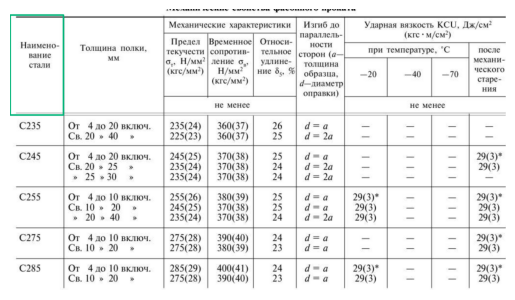

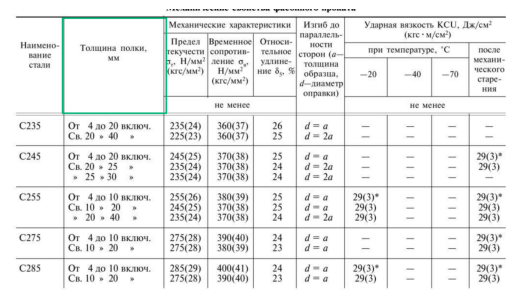

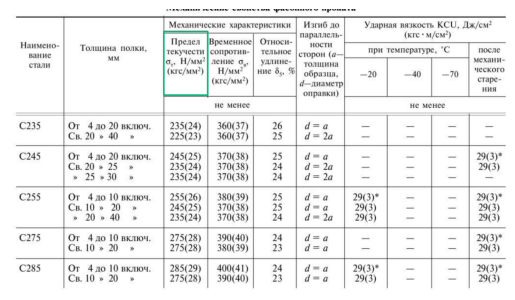

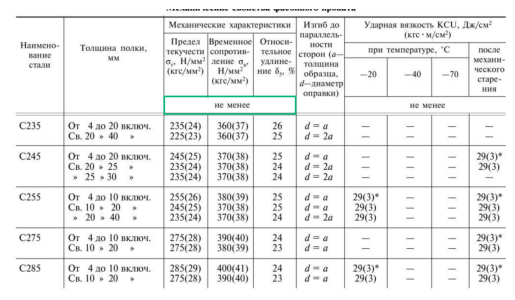

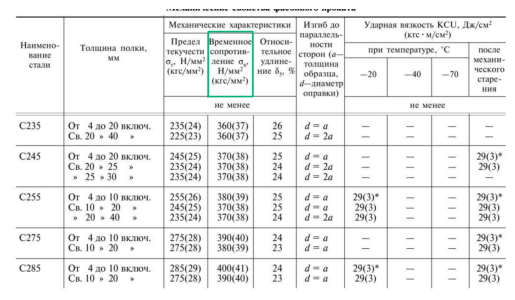

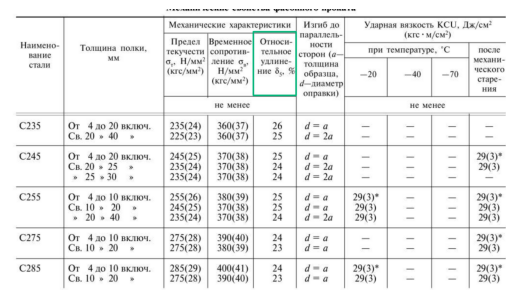

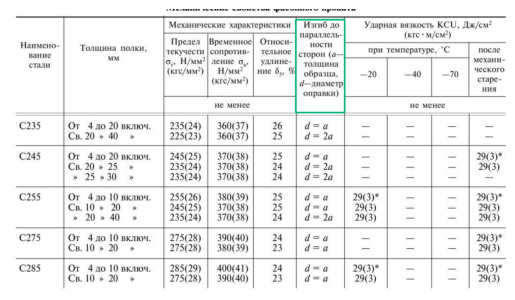

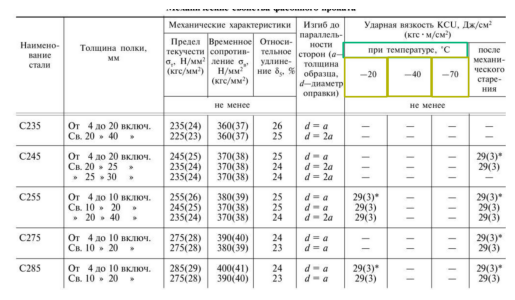

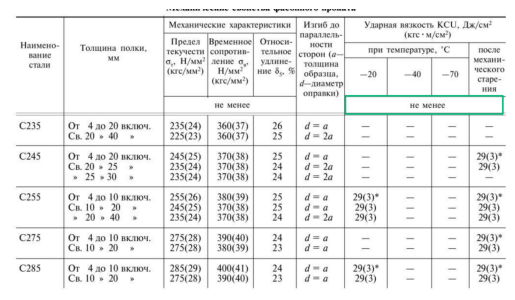

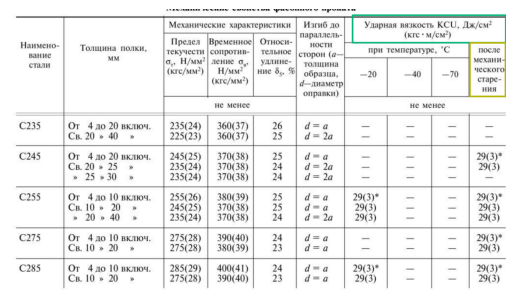

In [5]:
header_cell_dict = create_cell_dict(header_cells)
print(header_cell_dict)
for main_cell, overlapping_cells in header_cell_dict.items():
    visualize_cells_relationship(tables[0], main_cell, overlapping_cells)

In [19]:
structure = []

rectangle_text_dict = table_cell_text[0]

for cell in header_cells:
    structure.append(build_structure(cell,
                                     rectangle_text_dict, 
                                     header_cell_dict))
    
print(rectangle_text_dict)
print(header_cell_dict)
print(structure)

{(1, 41, 365, 724): 'Наимсно- ванис стали ', (1, 1697, 358, 1914): 'C285 ', (10, 927, 364, 1217): 'C245 ', (11, 721, 362, 934): 'С235 ', (15, 1208, 360, 1496): 'C255 ', (19, 1491, 360, 1706): 'C275 ', (347, 1209, 1057, 1492): 'От 4 до 10 включ: Св: 10 20 20 40 ', (350, 1700, 1056, 1912): 'От 4 до 10 включ: Св: 10 20 ', (351, 922, 1051, 1216): 'От 4 до 20 включ Св: 20 25 25 30 ', (355, 1496, 1054, 1702): 'От 4 до 10 включ: Св: 10 20 ', (359, 62, 1068, 712): 'Толщина полки, ям ', (366, 722, 1052, 933): 'От 4 до 20 включ. Св: 20 40 ', (1046, 722, 1351, 932): '235(24) 225(23) ', (1047, 1494, 1350, 1702): '275(28) 275(28) ', (1050, 1216, 1348, 1488): '255(26) 245(25) 235(24) ', (1051, 153, 1351, 588): 'Предел текучести Н/мм? кгс /мм? 6x ', (1051, 1703, 1348, 1907): '285(29) 275(28) ', (1054, 597, 1952, 717): 'нс менсс ', (1057, 937, 1346, 1211): '245(25) 235(24) 235(24) ', (1344, 935, 1661, 1208): '370(38) 370(38) 370(38) ', (1345, 1219, 1662, 1487): '380(39) 370(38) 370(38) ', (1349, 1495,

In [30]:
def extract_record_text(records_list, rectangle_text_dict):
    records_list = sorted(records_list, key=lambda x: (x[0], x[1]))
    text_list = []
    for record_cell in records_list:
        if record_cell in rectangle_text_dict:
            text_list.append(rectangle_text_dict[record_cell])
        else:
            text_list.append(None)
    return text_list

In [37]:
records_text = []
for record in records_list:
    records_text.append(extract_record_text(record, rectangle_text_dict))

In [44]:
def fill_structure(structure: dict, 
                   data: list) -> None:
    """
    Recursively fills the hierarchical structure of cells with data based on the relationships.

    Args:
        structure (dict): A hierarchical structure of cells represented as a dictionary.
        data (list): A list of cell data to fill into the structure.
        rectangle_text_dict (dict): A dictionary mapping cell coordinates to their corresponding text.

    Returns:
        None
    """
    if isinstance(structure, list):
        for item in structure:
            for key, value in item.items():
                if isinstance(value, list) and not value:
                    if data:
                        item[key] = data.pop(0)
                else:
                    fill_structure(
                        value, data)
                    
    return structure

In [52]:
result_structure = []
for text in records_text:
    # print(text)
    result_structure.append(fill_structure(structure, text))

print(result_structure)

[[{'Наимсно- ванис стали ': 'С235 '}, {'Толщина полки, ям ': 'От 4 до 20 включ. Св: 20 40 '}, {'Предел текучести Н/мм? кгс /мм? 6x ': '235(24) 225(23) '}, {'нс менсс ': '360(37) 360(37) '}, {'Временное сопротив- ление 0 н" Н/мм? кгс/мм? ': '26 25 '}, {'Относи- тельное удлине- нис cс 55 ': 'd = a d = 2a '}, {'Изгиб до параллсль- ности сторон (q толщина образца; d_диамстр оправки) ': ''}, {'при тсмпсратурс , C ': [{'_20 ': ''}, {'_40 ': ''}, {'_70 ': ''}]}, {'_20 ': 'C245 '}, {'не менее ': 'От 4 до 20 включ Св: 20 25 25 30 '}, {'Ударная вязкость KCU, Дж/см? KгС м/см? ': [{'_40 ': '245(25) 235(24) 235(24) '}, {'_70 ': '370(38) 370(38) 370(38) '}, {'послс механи - чсского старс - НИя ': '25 24 24 '}]}, {'_40 ': 'd = a d = 2a d = 2a '}, {'_70 ': ''}, {'послс механи - чсского старс - НИя ': ''}], [{'Наимсно- ванис стали ': 'С235 '}, {'Толщина полки, ям ': 'От 4 до 20 включ. Св: 20 40 '}, {'Предел текучести Н/мм? кгс /мм? 6x ': '235(24) 225(23) '}, {'нс менсс ': '360(37) 360(37) '}, {'Временн

In [45]:
epsilon = 20

rectangles = record_cells.copy()
print(rectangles)
cell_counts = {}

for num_1, (_, y1_1, _, _) in enumerate(rectangles):
    for num_2, (_, y1_2, _, _) in enumerate(rectangles):
        if y1_1 in cell_counts and (num_1 != num_2) and abs(y1_1 - y1_2) <= epsilon:
            cell_counts[y1_1] += 1
        else:
            cell_counts[y1_1] = 1

print("cell_counts", cell_counts)

[(2581, 711, 2880, 938), (2288, 717, 2572, 934), (3140, 719, 3385, 934), (11, 721, 362, 934), (1663, 721, 1952, 931), (366, 722, 1052, 933), (1046, 722, 1351, 932), (1953, 722, 2285, 933), (2881, 722, 3132, 936), (1350, 725, 1667, 931), (351, 922, 1051, 1216), (10, 927, 364, 1217), (2282, 927, 2573, 1219), (2578, 929, 2876, 1223), (2884, 933, 3132, 1220), (1952, 934, 2284, 1217), (3145, 934, 3388, 1216), (1344, 935, 1661, 1208), (1669, 935, 1950, 1216), (1057, 937, 1346, 1211), (15, 1208, 360, 1496), (347, 1209, 1057, 1492), (2576, 1209, 2876, 1503), (3144, 1215, 3390, 1496), (1050, 1216, 1348, 1488), (2883, 1216, 3134, 1499), (1956, 1217, 2282, 1496), (2285, 1217, 2579, 1492), (1671, 1218, 1951, 1496), (1345, 1219, 1662, 1487), (2882, 1490, 3137, 1709), (19, 1491, 360, 1706), (2287, 1491, 2575, 1710), (2586, 1491, 2876, 1709), (3140, 1493, 3390, 1702), (1047, 1494, 1350, 1702), (1349, 1495, 1659, 1702), (1664, 1495, 1953, 1701), (1952, 1495, 2281, 1707), (355, 1496, 1054, 1702), (1, 1

In [55]:
from collections import defaultdict

def group_cells(cells, epsilon=20):
    grouped_dict = defaultdict(int)
    grouped_list = []

    # Sort by y1
    cells.sort(key=lambda x: x[1])

    current_group = None
    current_group_list = []
    group_count = 0

    for item in cells:
        if current_group is None:
            current_group = item[1]
            group_count += 1
            current_group_list.append(item)
        elif abs(item[1] - current_group) <= epsilon:
            group_count += 1
            current_group_list.append(item)
        else:
            # New subgroup
            average_value = int(round(current_group))
            grouped_dict[average_value] = group_count
            grouped_list.append(current_group_list)
            current_group = item[1]
            group_count = 1
            current_group_list = [item]

    # Add last subgroup
    if current_group is not None:
        average_value = int(round(current_group))
        grouped_dict[average_value] = group_count
        grouped_list.append(current_group_list)

    return dict(grouped_dict), grouped_list

epsilon = 20
result, records_list = group_cells(rectangles, epsilon)
print(result)
print(records_list)

{41: 3, 73: 1, 153: 3, 229: 2, 329: 3, 593: 2}
[[(1, 41, 365, 724), (2341, 42, 3388, 230), (359, 62, 1068, 712)], [(1953, 73, 2287, 707)], [(1051, 153, 1351, 588), (1355, 154, 1659, 598), (1663, 155, 1955, 590)], [(2277, 229, 3125, 331), (3143, 231, 3386, 597)], [(2583, 329, 2878, 596), (2884, 330, 3134, 599), (2287, 332, 2576, 599)], [(2292, 593, 3368, 717), (1054, 597, 1952, 717)]]


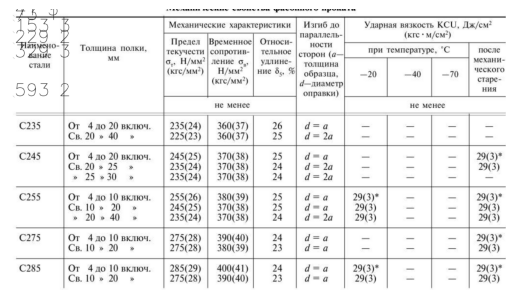

In [56]:
def add_lines_and_labels_to_image(cell_counts, table_image):
    keys = list(cell_counts.keys())
    values = list(cell_counts.values())
    
    image = table_image.copy()
    
    for i, key in enumerate(keys):
        x = 20 
        y = key
        
        cv2.line(image, (x, y), (x + 10, y + 10), (0, 0, 0), 1)
        cv2.putText(image, str(key) + " " + str(values[i]), (x+10, y), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 0), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

add_lines_and_labels_to_image(result, tables[0], epsilon)

In [ ]:
print(record_cells)
print(rectangle_text_dict)
for cell in record_cells:
    x1, y1, x2, y2 = cell
    table_copy = tables[0].copy()
    cell_image = table_copy[min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)]
    if cell in rectangle_text_dict:
        print(rectangle_text_dict[cell])
    # plt.imshow(cv2.cvtColor(cell_image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

### Research methods of parrallelic realisation

In [1]:
import time
import random

def process_image(image):
    n = random.randint(1, 5)
    time.sleep(n)
    return(image)

if __name__ == "__main__":
    images = [1, 2, 3, 4, 5]
    result = []

    start_time = time.time()
    for image in images:
        result.append(process_image(image))
    end_time = time.time()
    print("Time:", end_time - start_time, "seconds")
    print("Result", result)

Time: 18.002220153808594 seconds
Result [1, 2, 3, 4, 5]


In [16]:
import time
import random
from concurrent.futures import ThreadPoolExecutor

def process_image(image):
    n = random.randint(1, 5)
    time.sleep(n)
    # Здесь мы возвращаем пару (ключ, значение)
    return image, n

if __name__ == "__main__":
    images = [1, 2, 3, 4, 5]

    start_time = time.time()
    with ThreadPoolExecutor() as executor:
        results = dict(executor.map(process_image, images))
    end_time = time.time()
    print("Time:", end_time - start_time, "seconds")
    print("Results:", results)

Time: 5.004392623901367 seconds
Results: [1, 2, 3, 4, 5]


In [ ]:
import time
import random
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

def process_image(image):
    n = random.randint(1, 5)
    print(image, n)
    time.sleep(n)
    # Здесь мы возвращаем пару (ключ, значение)
    return image, n

if __name__ == "__main__":
    images = [1, 2, 3]  # Замените на ваш список изображений

    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
        results = list(executor.map(process_image, images))

    for image, n in results:
        print(f"Image processed with random value: {n}")

In [12]:
import concurrent.futures
import random
import time

nums = [1,2,3,4,5,6,7,8,9,10]

def f(x):
    n = random.randint(1, 5)
    print(x, n)
    time.sleep(n)
    return x * x
def main():
    # Make sure the map and function are working
    print([val for val in map(f, nums)])

    # Test to make sure concurrent map is working
    with concurrent.futures.ProcessPoolExecutor() as executor:
        print([val for val in executor.map(f, nums)])

if __name__ == '__main__':
    main()

1 4
2 3
3 3
4 5
5 2
6 3
7 5
8 3
9 4
10 5
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

### Poppler

In [ ]:
import os
import platform
import subprocess

def get_poppler_path():
    system = platform.system()
    
    if system == 'Windows':
        # На Windows, вы можете использовать "where" для поиска исполняемого файла
        result = subprocess.check_output("where pdfinfo", shell=True)
        pdfinfo_path = result.decode("utf-8").strip()
        poppler_path = os.path.dirname(pdfinfo_path)
        return poppler_path
    elif system == 'Linux':
        # На Linux, вы можете проверить путь к исполняемому файлу
        result = subprocess.check_output("which pdfinfo", shell=True)
        pdfinfo_path = result.decode("utf-8").strip()
        poppler_path = os.path.dirname(pdfinfo_path)
        return poppler_path
    else:
        # Другие операционные системы
        print("Unsupported OS")
        exit()

poppler_path = get_poppler_path()
print(poppler_path)

### Quantization of MASK-RCNN

In [10]:
import torch
import torchvision
from torch.quantization import quantize, prepare
import numpy as np
import torch.nn as nn

from PIL import Image
from maskrcnn import infer_utils
# from infer_utils import get_outputs
from torchvision.transforms import transforms as transforms
from maskrcnn.class_names import INSTANCE_CATEGORY_NAMES, CELLS_CATEGORY_NAMES

In [17]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
    pretrained=False, num_classes=91
)
class_names = CELLS_CATEGORY_NAMES
# class_names = INSTANCE_CATEGORY_NAMES

model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4, bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names), kernel_size=(1, 1), stride=(1, 1))

# Set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
weights = os.path.join(os.getcwd(), "maskrcnn", "weights", "best_cell_detection.pth")
ckpt = torch.load(weights, map_location=device)
model.load_state_dict(ckpt['model'])
model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [18]:
quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)

In [19]:
torch.save(quantized_model.state_dict(), 'best_cell_detection_quantized_model.pth')